# Imports

In [1]:
from astropy import units as u
from astropy.coordinates import SkyCoord, angular_separation, get_sun
from astropy.time import Time,TimeMJD
from scipy.optimize import curve_fit
import numpy as np
import pandas as pd
import math
from scipy.interpolate import CubicSpline
from matplotlib import pyplot as plt
from matplotlib import animation as pan
import time
from IPython.display import display, clear_output
import os
#import plotly # von Leo zum Interaktiven Anzeigen von Grafiken!!
#from matplotlib.backends.backend_pdf import PdfPages

/tmp/ipykernel_350451/2776935530.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Part mit Definitionen

In [2]:
## GET SUN POSITION

def sun_pos(times,skyra=278.416201, skydec=-21.061048):
    c = SkyCoord(skyra, skydec, frame='icrs', unit='deg')
    times = Time((times), format='mjd')
    #tmjd = times.mjd
    #t.utc
    near = []
    #sepa=[]
    #sepadeg=[]
    for t in times:
        sunloc = get_sun(t)
        sep = angular_separation(c.ra,c.dec, sunloc.ra,sunloc.dec)
        
        condition = np.rad2deg(sep)<8*u.deg
        #sepa.append(sep)
        #sepadeg.append(np.rad2deg(sep))
        if condition ==True :
            near.append(t.value)
            #if 55554 < np.float64(t.value) < 55570: print(sunloc)
    return near

In [3]:
def undersampling(input_data, spline_bin, fixed_ends: bool = False, mean_ends: bool = False):
    
    new_array = []
    for i in range(0, len(input_data), spline_bin):
        mean = 0
        den = 0
        if ((i+spline_bin-1)<len(input_data)): ##check if you're not at the end of the LC
            
            for j in range(0, spline_bin, 1):
                if (math.isnan(input_data[i+j]) != True):
                    mean += input_data[i+j]
                    den += 1
            if den==0: ## just nan in the spline_bin segments
                new_array.append(0)
            else:
                new_array.append(mean/den)
            
    if fixed_ends:
        for i in range(0,spline_bin,1):
            if (math.isnan(input_data[i]) == False):
                new_array.insert(0, input_data[i])
                break
        
        for i in range(len(input_data)-1,len(input_data)-1-spline_bin,-1):
            if (math.isnan(input_data[i]) == False):
                new_array.insert(len(new_array), input_data[i])
                break
    
    if mean_ends:
        mean = 0
        den = 0
        for i in range(0,spline_bin//2,1):
            if (math.isnan(input_data[i]) != True):
                mean += input_data[i]
                den += 1
        if den==0: ## just nan in the spline_bin segments
            new_array.insert(0,0)
        else:
            new_array.insert(0,mean/den)
        mean = 0
        den = 0        
        for i in range(len(input_data)-1,len(input_data)-1-spline_bin//2-len(input_data)%spline_bin,-1):
            if (math.isnan(input_data[i]) != True):
                mean += input_data[i]
                den += 1
        if den==0: ## just nan in the spline_bin segments
            new_array.insert(len(new_array),0)
        else:
            new_array.insert(len(new_array),mean/den)
    
    return np.array(new_array)

In [4]:
def my_sin(x, amplitude, phase, offset, period:float=2.2):
        return np.sin(x * ((2 * np.pi) / (period * 365.25)) + phase) * amplitude + offset

Periode von Sara hat eigentlich auch einen Fehler!!

# Parameters

- source coordinates
- path_lc
- time interval (From, To)
- scaling power?
- flux or flux_fixed?
- spline_bin!!!
- edges yes or no?

In [5]:
def detr_amplitude(spline_bin: int = 15, path_lc: str = "/home/praktikum/kfischer/auswertung/PG1555/2_4fgl_j1555.7+1111_lightcurve.npy",
                   FROM: float = 54680, TO: float = 60230, scaling_power: int = 8, period_time: float = 2.2,
                   skyra_source: float = 238.929350, skydec_source: float = 11.190101, 
                   TAKEflux_fixed: bool = True, fixed_ends: bool = False, mean_ends: bool = False,
                   path_fig: str = "/home/praktikum/kfischer/auswertung/PG1555/splines/",
                   savefigs: bool = True, cut_edge: bool = True, namen='default'):
    #####  CHECK IF PATHS EXIST OTHERWISE CREATE THEM  #####

    if not os.path.exists(path_lc):
        os.makedirs(path_lc)
        print(f"The new directory {path_lc} is created!")

    if not os.path.exists(path_fig):
        os.makedirs(path_fig)
        print(f"The new directory {path_fig} is created!")
    
    
    ##### DATA IMPORT ######
    
    data_lc = np.load(path_lc, allow_pickle=True,encoding='latin1')
    df_fixed = pd.DataFrame({k: data_lc.tolist()[k] for k in (
        'tmin_mjd', 'tmax_mjd', 'flux_fixed', 'flux_err_fixed', 'ts', 'flux_ul95', 'fit_quality', 'fit_success')})
    df = pd.DataFrame({k: data_lc.tolist()[k] for k in (
        'tmin_mjd', 'tmax_mjd', 'flux', 'flux_err', 'ts', 'flux_ul95', 'fit_quality', 'fit_success')})
       
    ## SELECT QUALITY ##
    
    df_fixed = df_fixed.where((df_fixed['fit_quality'] == 3) & (df_fixed['fit_success'] == True))
    df = df.where((df['fit_quality'] == 3) & (df['fit_success'] == True))
    
    ##########################################
    ##########################################
    ###########    FILTERS    ################
    ##########################################
    ##########################################
    ###  ---> pd.Dataframe.where ersetzt values mit nan, wenn die Bedingung nicht zutrifft
    
    ###### SELECT TIME RANGE ######
       
    df_fixed = df_fixed[df_fixed['tmin_mjd'].between(FROM,TO)].reset_index(drop=True)
    df = df[df['tmin_mjd'].between(FROM,TO)].reset_index(drop=True)
    
    #file_name_results = './results_data/results_file_' + str(FROM) + '_' + str(TO) + '_10k.txt'
    
    ###### REMOVE POINTS WITH ERROR/FLUX > 100% and TS<1 ######
    
    df_fixed['flux_fixed'] = df_fixed['flux_fixed'].where(
        (df_fixed['flux_err_fixed']<df_fixed['flux_fixed'])&(df_fixed['ts']>1)
        )
    df['flux'] = df['flux'].where(
        (df['flux_err']<df['flux'])&(df['ts']>1)
        )
    df_fixed['flux_err_fixed'] = df_fixed['flux_err_fixed'].where(
        (df_fixed['flux_err_fixed']<df_fixed['flux_fixed'])&(df_fixed['ts']>1)
        )
    df['flux_err'] = df['flux_err'].where(
        (df['flux_err']<df['flux'])&(df['ts']>1)
        )
        
    ###### SUN FILTER ######
    time_sun = sun_pos(df['tmin_mjd'].values, skyra= skyra_source, skydec= skydec_source)
    #print(time_sun)
    for i in range (0, len(time_sun)):
        df['flux'] = df['flux'].where(df['tmin_mjd'] != time_sun[i])
        df['flux_err'] = df['flux_err'].where(df['tmin_mjd'] != time_sun[i])
    for i in range (0, len(time_sun)):
        df_fixed['flux_fixed'] = df_fixed['flux_fixed'].where(df_fixed['tmin_mjd'] != time_sun[i])
        df_fixed['flux_err_fixed'] = df_fixed['flux_err_fixed'].where(df_fixed['tmin_mjd'] != time_sun[i])
    
    ####################################################################################
    ####################################################################################
    ####################################################################################
    ####################################################################################
        
    ## TAKE TIME, FLUX AND FLUX_ERR ##
        
    time_fixed = df_fixed['tmin_mjd'].values #(df_fixed['tmin_mjd'].values + df_fixed['tmax_mjd'].values) / 2
    flux_fixed = df_fixed['flux_fixed'].values * 10**scaling_power
    flux_err_fixed = df_fixed['flux_err_fixed'].values * 10**scaling_power
    
    time = df['tmin_mjd'].values #(df['tmin_mjd'].values + df['tmax_mjd'].values) / 2
    flux = df['flux'].values * 10**scaling_power
    flux_err = df['flux_err'].values * 10**scaling_power
    
    ####################################################################################
    ####################################################################################

    #### CHOOSE BETWEEN FLUX AND FLUX_FIXED #######

    if TAKEflux_fixed:
        time = time_fixed
        flux = flux_fixed
        flux_err = flux_err_fixed
    else:
        time
        flux
        flux_err
    
    ##############################
    ########  SPLINE  ############
    ##############################
    
    if fixed_ends:
        under_sample_flux = undersampling(flux, spline_bin, fixed_ends)
        under_sample_time = undersampling(time, spline_bin, fixed_ends)
    elif mean_ends:
        under_sample_flux = undersampling(flux, spline_bin, fixed_ends=False, mean_ends=True)
        under_sample_time = undersampling(time, spline_bin, fixed_ends=True, mean_ends=False)
    else:
        under_sample_flux = undersampling(flux, spline_bin, fixed_ends, mean_ends)
        under_sample_time = undersampling(time, spline_bin, fixed_ends, mean_ends)
        
    spline = CubicSpline(under_sample_time, under_sample_flux)
    flux_norm = flux - spline(time)

    detr_data_df = pd.DataFrame(data={'time':time, 'detr_flux':flux_norm})

    ####################################################################################
    ########  AMPLITUDE FIT  ###########################################################
    ####################################################################################

    #### CUT EDGES FROM DATA  ####
    ####  NACH SARA HALBES SPLINE_BINNING  #####
    
    if cut_edge:
        reduce = round(spline_bin/2.0) # 15//2 = 7 statt 7.5

        flux_red = flux_norm[reduce:-reduce] ## cut the outer {reduce} points from the data to fit
        flux_err_red = flux_err[reduce:-reduce]
        time_red = time[reduce:-reduce]
    else:
        reduce = 0
        flux_red = flux_norm
        flux_err_red = flux_err
        time_red = time
    
    ####  CHECK DATA (NAN OR INF)  ####
    
    time_red1 = []
    flux_red1 = []
    flux_err_red1 = []
    for i in range(len(flux_red)):
        if not math.isnan(flux_red[i]):
            time_red1.append(time_red[i])
            flux_red1.append(flux_red[i])
            flux_err_red1.append(flux_err_red[i])
    time_red = time_red1
    flux_red = flux_red1
    flux_err_red = flux_err_red1
    
    
    #fix_freq = 2 *np.pi/ (period_time * 365.25)
    guess_amplitude = 3*np.std(flux_red)/(2**0.5)
    guess_phase = 2.57037649 #np.pi
    guess_offset = np.mean(flux_red)    
    
    p0=[guess_amplitude, guess_phase, guess_offset]
    
    
    
    popt, pcov = curve_fit(lambda x, a, ph, off: my_sin(x,amplitude=a,phase=ph,offset=off,period=period_time), 
                    time_red, flux_red,p0=p0, sigma=flux_err_red) #, absolute_sigma=True) pcov wird bei True nicht hoch skaliert
    perr= np.sqrt(np.diag(pcov))
    
    
    #data_first_guess = my_sin(time, *p0, period=period_time)
    data_fit = my_sin(time, *popt,period=period_time)
    data_fit_perr = my_sin(time, popt[0]+perr[0], popt[1], popt[2],period=period_time)
    data_fit_merr = my_sin(time, popt[0]-perr[0], popt[1], popt[2],period=period_time)

    fit_params = popt
    amplitude = fit_params[0]

    ####################################################################################
    #########  CHI-SQUARED  ############################################################
    ####################################################################################
    
    summe = 0
    for i in range(len(flux_red)):
        summe += ((data_fit[reduce+i]-flux_red[i])/flux_err_red[i])**2 #Chisq aus curve_fit function (see documentation)
        #summe += ((data_fit[reduce+i]-flux_red[i])**2/data_fit[reduce+i])  # Definition von Chi Squared sigma**2 = haeufigkeit
    
    chi = summe
    chi_red = chi/(len(flux_red)-3.0)
    
    #print(f"{chi_red:.2f}")
    
    ####################################################################################
    #########  MEAN FLUX  ############################################################
    ####################################################################################
    
    #f_mean = np.mean(flux_red + spline(time_red))
    
    weight = np.power(flux_err_red,-2)
    f_mean = np.average(flux_red + spline(time_red),weights=weight)
    f_mean_err = np.sqrt(1/np.sum(weight))
    
    ####################################################################################
    #########  SAVE FIGURES FOR EVALUATION  ############################################
    ####################################################################################

    fig, (ax1, ax2) = plt.subplots(2, figsize=(12,8))
    fig.suptitle(f"Spline binning of {spline_bin} (x28) days \n"+"$\chi_{red}^2 = $"+f"{chi_red:.2f}")
    
    ax1.errorbar(time, flux, yerr=flux_err, xerr=np.linspace(14,14,len(time)),
                     marker='.', color='darkblue', linestyle='', capsize=2,
                     label=f'{namen}, 28-day binning')
    xx = np.linspace(min(time), max(time), 10000)
    ax1.plot(xx, spline(xx), color='tab:orange', label='Spline, '+str(spline_bin)+' (x28) days Spline binning')
    ax1.scatter(under_sample_time, under_sample_flux, marker='o', linewidth=1.5, color='orange')
    ax1.tick_params(axis='both', labelsize=13)
    ax1.set(xlabel='Time [MJD]',ylabel=r'Photon flux $[\mathrm{ph}/\mathrm{cm}^2/\mathrm{s}]\cdot10^{-%i}$'% scaling_power)
    #ax1.xlabel('MJD', fontsize=15)
    #ax1.ylabel(r'Flux [$\times 10^{-%i}$ cm$^{-2}$ s$^{-1}$]' % scaling_power, fontsize=15)
    ax1.grid(linewidth=0.6)
    ax1.legend(fontsize=13, loc='upper left')
    for i in range(0, len(time_sun)):
        if i==0:
            ax1.axvline(x=time_sun[i], color='yellow', alpha=0.3, label='Sun cut')
        ax1.axvline(x=time_sun[i], color='yellow', alpha=0.3)
    #ax1.savefig('lc.pdf', format='pdf', dpi=1000)
    
    #fig, ax = plt.subplots(figsize=(6,4))
    ax2.errorbar(time,flux_norm,yerr=flux_err,xerr=np.linspace(14,14,len(time)),fmt='k.',ecolor='darkblue',
                 label='Detrended photon flux with '+str(spline_bin)+' (x28) days Spline bin',
                 capsize=2)
    
    ax2.plot(time, data_fit, color='r', label='Sine Fit')
    ax2.plot(time, data_fit_merr, color='orange', label='Minimal Sine Fit')
    ax2.plot(time, data_fit_perr, color='green', label='Maximal Sine Fit')
    ax2.fill_between(time, data_fit_perr, data_fit_merr, alpha=.5, color='r', label='1-sigma amplitude interval')
    
    ax2.set(xlabel='Time [MJD]',ylabel=r'Photon flux $[\mathrm{ph}/\mathrm{cm}^2/\mathrm{s}]\cdot10^{-%i}$'% scaling_power)
    #ax2.set_ylabel(r'Photon flux [$\times 10^{-8} s^{-%x} cm^{-2}$]'% scaling_power)
    #ax2.set_xlabel('MJD')
    ax2.grid(linewidth=0.6)
    ax2.legend(loc='upper left')
    #ax2.set_ylim([-3, 6])
    for i in range(0, len(time)):
        if i<reduce or i >= len(time)-reduce:
            if i == 0:
                ax2.axvline(x=time[i], color='orange', alpha=0.6, label='Sine fit cut')
            else:
                ax2.axvline(x=time[i], color='orange', alpha=0.6)

    '''
    existing_pdf_path = path_fig+'spline_'+str(1)+'.pdf'
    with PdfPages(existing_pdf_path,'a') as pdf:
        pdf.savefig()  # Saves the current figure into a pdf page
        plt.close()
    '''
    
    if savefigs:
        fig.savefig(path_fig+'spline_'+str(spline_bin)+'.png',format='png',dpi=300) # kleiner pdf, und noch kleiner eps
    plt.close()
    #del(fig)
    ####################################################################################
    ####################################################################################
    
    return (amplitude,perr[0], chi_red, f_mean, f_mean_err)#fig)

## Interessanter Fitter mit der Moeglichkeit, Variablen zu fixen

# Analyse von allen 5 Quellen

In [6]:
quellen = ['PG_1553', 'OJ_014', 'PKS_0454', 'PKS_2155', 'S5_0716']
namen = ['PG 1553+113', 'OJ 014', 'PKS 0454-234', 'PKS 2155-304', 'S5 0716+714']

lists_path_lcs = ['LCs_Kilian/1_4fgl_j1555.7+1111_lightcurve.npy',
                  'LCs_Kilian/1_4fgl_j0811.4+0146_lightcurve.npy',
                  'LCs_Kilian/1_4fgl_j0457.0-2324_lightcurve.npy',
                  'LCs_Kilian/1_4fgl_j2158.8-3013_lightcurve.npy',
                  'LCs_Kilian/1_4fgl_j0721.9+7120_lightcurve.npy']

# lists_path_lcs = ['LCs_Sara/fullTime_4fgl_j1555.7+1111_lightcurve.npy',
#                   'LCs_Sara/fullTime_4fgl_j0811.4+0146_lightcurve.npy',
#                   'LCs_Sara/fullTime_4fgl_j0457.0-2324_lightcurve.npy',
#                   'LCs_Sara/fullTime_4fgl_j2158.8-3013_lightcurve.npy',
#                   'LCs_Sara/fullTime_4fgl_j0721.9+7120_lightcurve.npy']


# Coordinates from Saras Tabelle
lists_skyra_source = [238.93169, 122.86418, 74.26096, 329.71409, 110.48882]
lists_skydec_source = [11.18768, 1.77344, -23.41384, -30.22556, 71.34127]
lists_period_glsp = [2.1, 4.1, 3.5, 1.7, 2.6]
lists_period_glsp_err = [0.2, .4, .4, .1, .4]

lists_period_time_sara = [2.2, 4.1, 3.6, 1.7, 2.7]
lists_period_time_penil = [2.2, 4.3, 2.6, 1.7, 2.8]

list_pos = [29, 39, 24, 21, 22]

input_dict = dict()
for i in range(5):
    input_dict[quellen[i]] = [lists_path_lcs[i], lists_skyra_source[i], lists_skydec_source[i], 
                              lists_period_time_sara[i], lists_period_time_penil[i], 
                              lists_period_glsp[i], lists_period_glsp_err[i], list_pos[i], namen[i]]
# input_dict = {'PG_1553', 
#               'OJ_014', 
#               'PKS_0454', 
#               'PKS_2155', 
#               'S5_0716'}

In [7]:
standard_path = '/home/praktikum/kfischer/auswertung/'

## Amplituden fit fuer alle 5 Quellen mit Vergleich uncut mean

Next step would be to divide the big cell into smaller ones and making it more modular (idea is to only compute the detr_amplitude once)

##########
Quelle: PG_1553
2: 	0.9884
3: 	1.2483
4: 	1.4075
5: 	1.6611
6: 	1.8939
7: 	1.8701
8: 	1.9784
9: 	2.2958
10: 	2.2340
11: 	2.2520
12: 	2.2810
13: 	2.3406
14: 	2.2957
15: 	2.4012
16: 	2.6084
17: 	2.5187
18: 	2.5137
19: 	2.4806
20: 	2.5398
21: 	2.4043
22: 	2.3874
23: 	2.3197
24: 	2.2892
25: 	2.2829
26: 	2.3266
27: 	2.2803
28: 	2.2676
29: 	2.2258
30: 	2.3924
31: 	2.3416
32: 	2.3169
33: 	2.2899
34: 	2.2756
35: 	2.4984
36: 	2.4509
37: 	2.4414
38: 	2.4408
39: 	2.3776
40: 	2.3914
41: 	2.3478
42: 	2.3735
43: 	2.4153
44: 	2.4659
45: 	2.4130
46: 	2.3648
47: 	2.4441
48: 	2.3799
49: 	2.3470
50: 	2.3787
51: 	2.3765
52: 	2.4303
53: 	2.4183
54: 	2.3837
55: 	2.3756
56: 	2.3745
57: 	2.3725
58: 	2.3947
59: 	2.4247
60: 	2.4307
61: 	2.4345
62: 	2.4161
63: 	2.3949
64: 	2.3775
65: 	2.3744
66: 	2.3888
67: 	2.4196
68: 	2.4269
69: 	2.5022
70: 	2.4961
71: 	2.4912
72: 	2.4919
73: 	2.4948
74: 	2.5070
75: 	2.5277
76: 	2.5275
77: 	2.5280
78: 	2.5212
79: 	2.4975
80: 	2.5017
81: 	2.5005
82: 	2.3793
83: 	2.37

80 _v2: 	60.4276
81 _v2: 	60.2733
82 _v2: 	60.0976
83 _v2: 	59.6951
84 _v2: 	59.0724
85 _v2: 	59.2184
86 _v2: 	58.8462
87 _v2: 	58.5315
88 _v2: 	58.4624
89 _v2: 	58.7555
90 _v2: 	59.0056
91 _v2: 	59.4646
92 _v2: 	60.0322
93 _v2: 	60.1075
94 _v2: 	60.1686
95 _v2: 	59.8243
96 _v2: 	59.7160
97 _v2: 	59.5288
98 _v2: 	59.6597
99 _v2: 	59.7974
100 _v2: 	59.9021
##########
Quelle: PKS_2155
2: 	2.9015
3: 	4.6361
4: 	5.0314
5: 	6.1905
6: 	6.8109
7: 	7.7871
8: 	8.3607
9: 	8.1478
10: 	8.7759
11: 	9.2754
12: 	9.5559
13: 	9.5739
14: 	10.2103
15: 	10.0193
16: 	10.1922
17: 	10.2658
18: 	10.2043
19: 	9.9685
20: 	9.9905
21: 	9.7474
22: 	10.1420
23: 	9.9328
24: 	9.9306
25: 	9.9586
26: 	10.3398
27: 	10.2345
28: 	10.1774
29: 	10.0264
30: 	10.0952
31: 	9.8643
32: 	9.9381
33: 	10.1361
34: 	9.9959
35: 	10.6536
36: 	10.4187
37: 	10.5471
38: 	10.5402
39: 	10.3783
40: 	10.5780
41: 	10.3612
42: 	10.3531
43: 	10.3189
44: 	10.2669
45: 	10.2861
46: 	10.3765
47: 	10.3860
48: 	10.4188
49: 	10.5040
50: 	10.7159
51: 	1

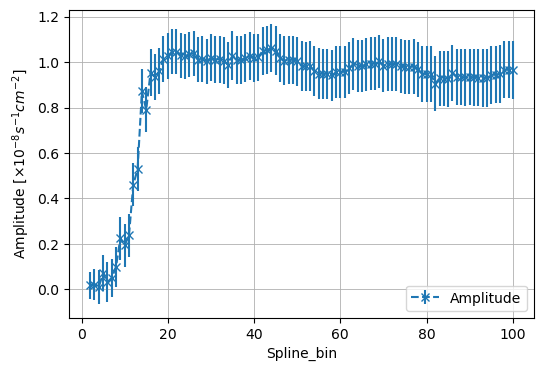

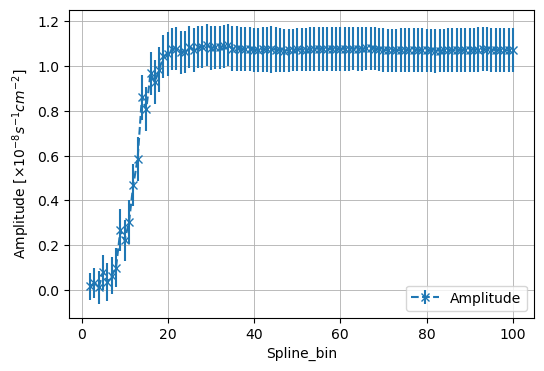

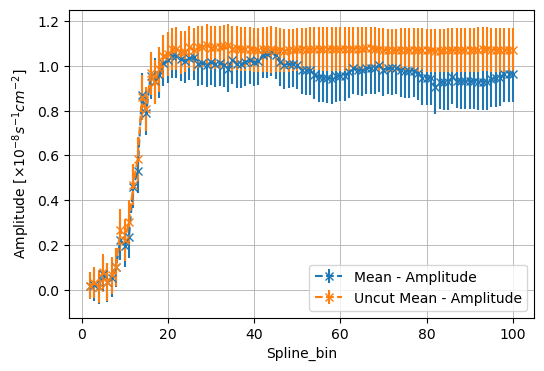

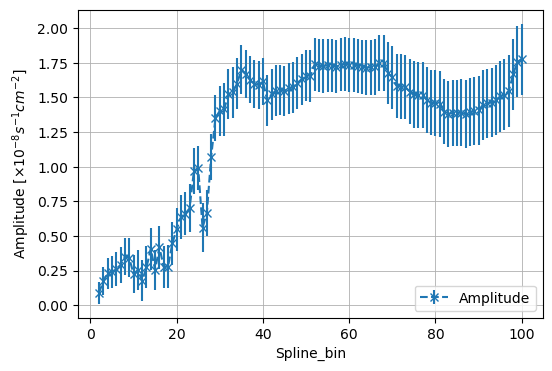

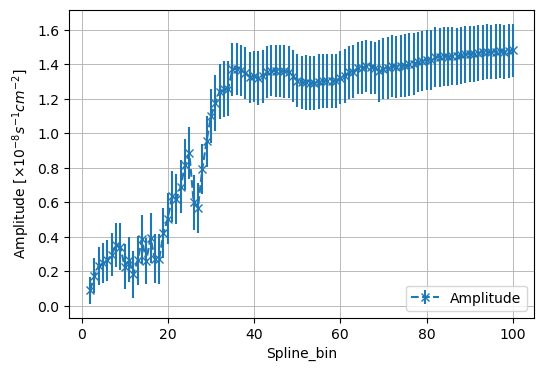

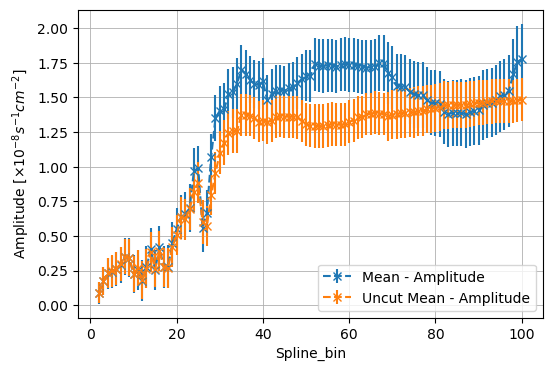

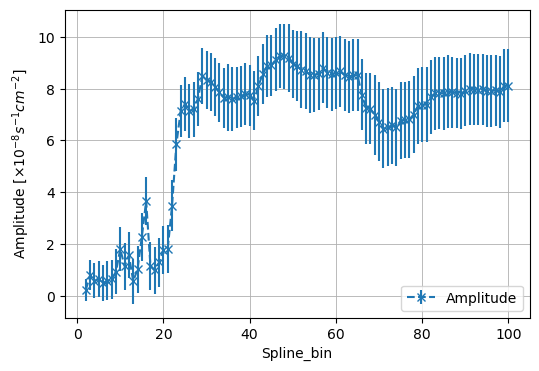

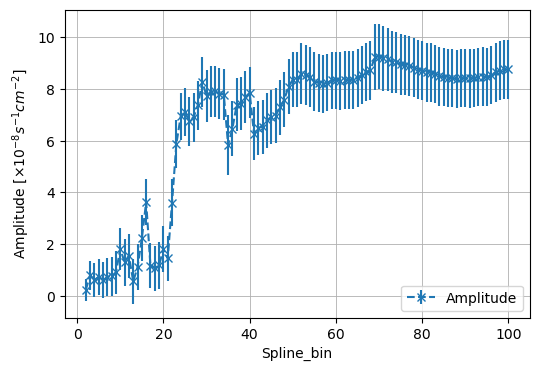

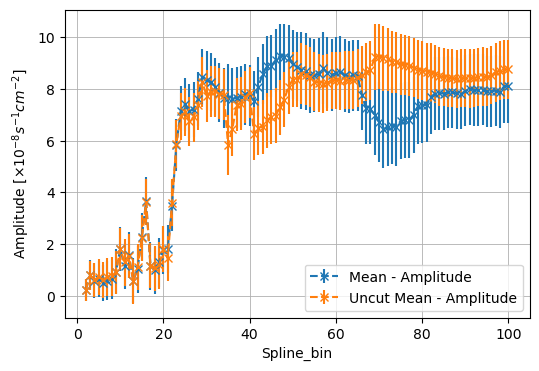

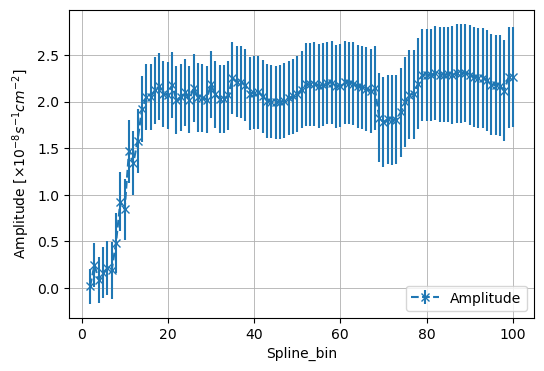

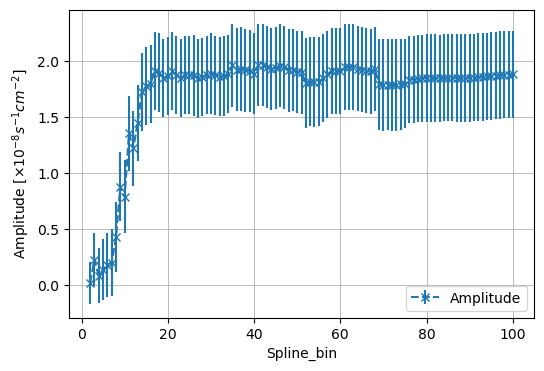

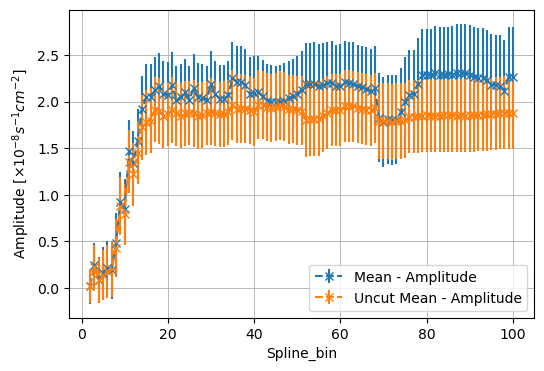

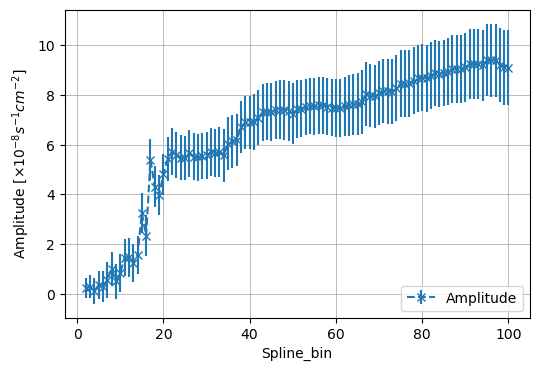

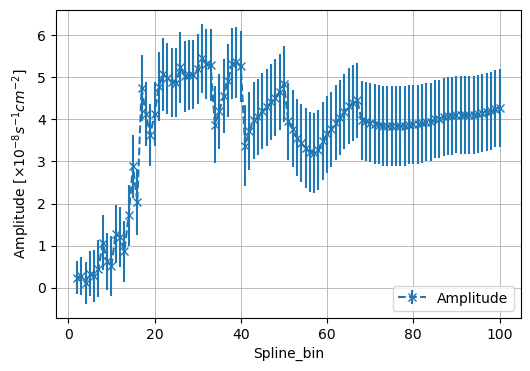

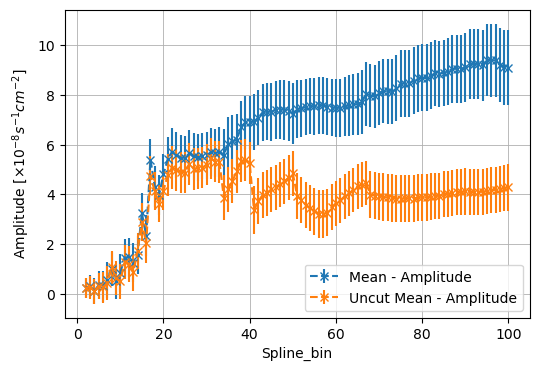

In [8]:
data_out ={}
for i in [0,1,2,3,4]:
    output = [[],[],[],[],[],[]]
    output_v2 = [[],[],[],[],[],[]]
    print('#'*10)
    print(f"Quelle: {quellen[i]}")
    for binning in range(2,101,1):
        amp, amp_err, chi_r, f_mean, f_mean_err = detr_amplitude(spline_bin=binning, fixed_ends=False, mean_ends=True, 
                                      path_fig=standard_path+quellen[i]+'/splines_mean_ends_Kilian/',
                                      path_lc=standard_path+lists_path_lcs[i], 
                                      TAKEflux_fixed = True, FROM=0, TO=70000, 
                                      period_time=lists_period_glsp[i],namen=input_dict[quellen[i]][8])
        output[0].append(binning)
        output[1].append(amp)
        output[2].append(amp_err)
        output[3].append(chi_r)
        output[4].append(f_mean)
        output[5].append(f_mean_err)
        print(f"{binning}: \t{chi_r:.4f}")
        
    scaling_power = 8
    
    fig, ax = plt.subplots(figsize=(6,4))
    ax.errorbar(output[0], list(map(abs, output[1])),yerr=output[2],marker = 'x', linestyle = '--', label='Amplitude')
    ax.set_ylabel(r'Amplitude [$\times 10^{-%s} s^{-1} cm^{-2}$]'% scaling_power)
    ax.set_xlabel('Spline_bin')
    ax.legend(loc='lower right')
    ax.grid(linewidth=0.6)
    fig.savefig(standard_path+quellen[i]+'/splines_mean_ends_Kilian/amplitude_evolution.png',format='png',dpi=300)
    
    for binning in range(2,101,1):
        amp, amp_err, chi_r, f_mean, f_mean_err = detr_amplitude(spline_bin=binning, fixed_ends=False, mean_ends=True, cut_edge = False,
                                      path_fig=standard_path+quellen[i]+'/splines_mean_ends_v2_Kilian/',
                                      path_lc=standard_path+lists_path_lcs[i], 
                                      TAKEflux_fixed = True, FROM=0, TO=70000, 
                                      period_time=lists_period_glsp[i],namen=input_dict[quellen[i]][8])
        output_v2[0].append(binning)
        output_v2[1].append(amp)
        output_v2[2].append(amp_err)
        output_v2[3].append(chi_r)
        output_v2[4].append(f_mean)
        output_v2[5].append(f_mean_err)
        print(f"{binning} _v2: \t{chi_r:.4f}")

    data_out[quellen[i]]=[output,output_v2]
    fig, ax = plt.subplots(figsize=(6,4))
    ax.errorbar(output_v2[0], list(map(abs, output_v2[1])),yerr=output_v2[2],marker = 'x', linestyle = '--', label='Amplitude')
    ax.set_ylabel(r'Amplitude [$\times 10^{-%s} s^{-1} cm^{-2}$]'% scaling_power)
    ax.set_xlabel('Spline_bin')
    ax.legend(loc='lower right')
    ax.grid(linewidth=0.6)
    fig.savefig(standard_path+quellen[i]+'/splines_mean_ends_v2_Kilian/amplitude_evolution.png',format='png',dpi=300)
    
    fig, ax = plt.subplots(figsize=(6,4))
    #ax.errorbar(output[0], output[1],yerr=output[2],marker = 'x', linestyle = '--', label='Fixed - Amplitude')
    ax.errorbar(output[0], list(map(abs, output[1])), yerr=output[2], marker = 'x', linestyle = '--', 
                label='Mean - Amplitude')
    ax.errorbar(output_v2[0], list(map(abs, output_v2[1])), yerr=output_v2[2],marker = 'x', linestyle = '--', 
                label='Uncut Mean - Amplitude')
    ax.set_ylabel(r'Amplitude [$\times 10^{-%s} s^{-1} cm^{-2}$]'% scaling_power)
    ax.set_xlabel('Spline_bin')
    ax.legend(loc='lower right')
    ax.grid(linewidth=0.6)
    fig.savefig(standard_path+quellen[i]+'/amplitude_evolution_Kilian.png',format='png',dpi=300)

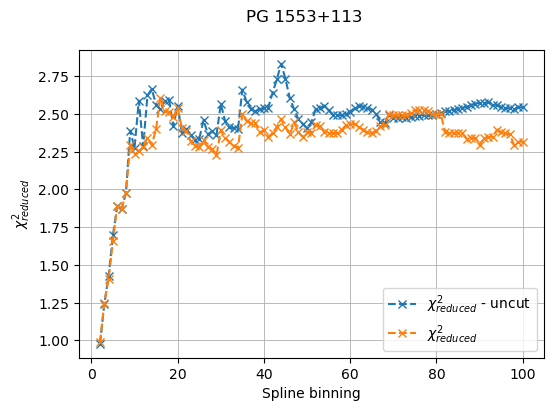

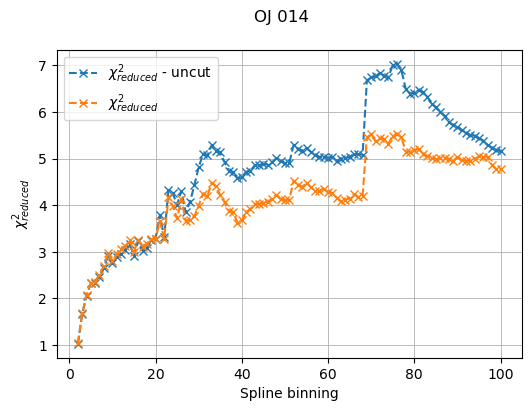

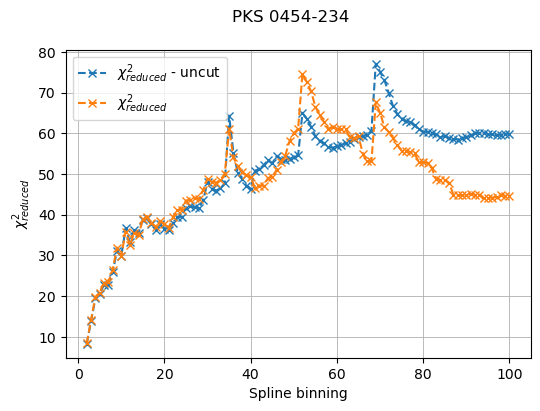

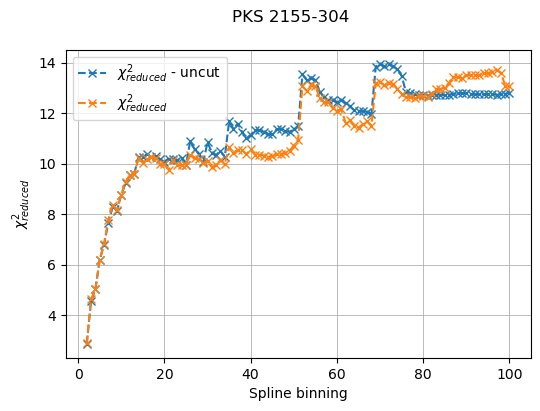

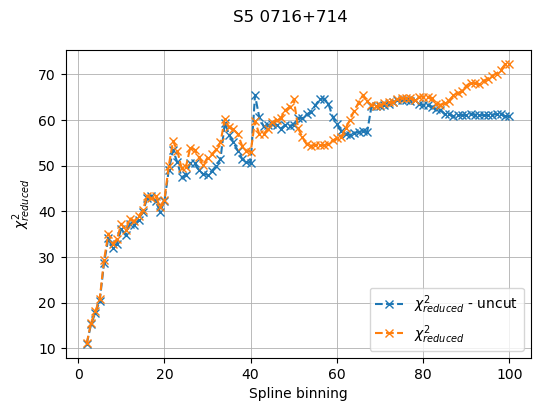

In [9]:
chired = []
chired_v2 = []
for k in data_out.keys():
    chired.append(data_out[k][0][3])
    chired_v2.append(data_out[k][1][3])
    fig, ax = plt.subplots(figsize=(6,4))
    fig.suptitle(input_dict[k][8])
    ax.plot(data_out[k][1][0], data_out[k][1][3], 'x--', label='$\chi^2_{reduced}$ - uncut')
    ax.plot(data_out[k][0][0], data_out[k][0][3], 'x--', label='$\chi^2_{reduced}$')
    ax.set_ylabel('$\chi^2_{reduced}$')
    ax.set_xlabel('Spline binning')
    ax.legend()
    ax.grid(linewidth=0.6)
    fig.savefig(standard_path+k+'/chi_reduced_Kilian.png',format='png',dpi=300)

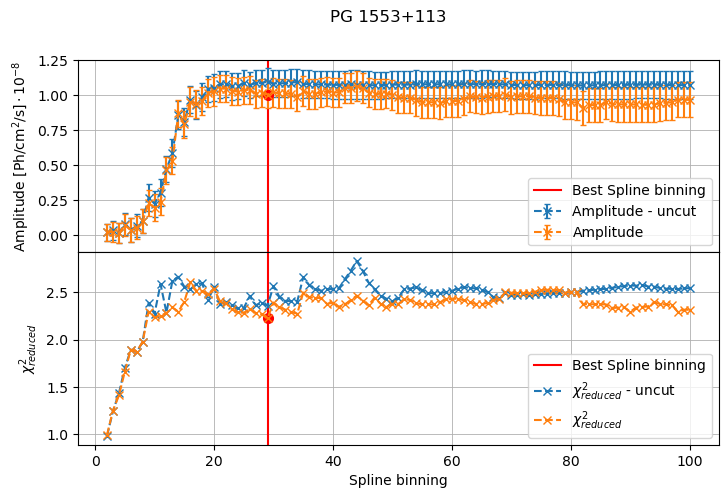

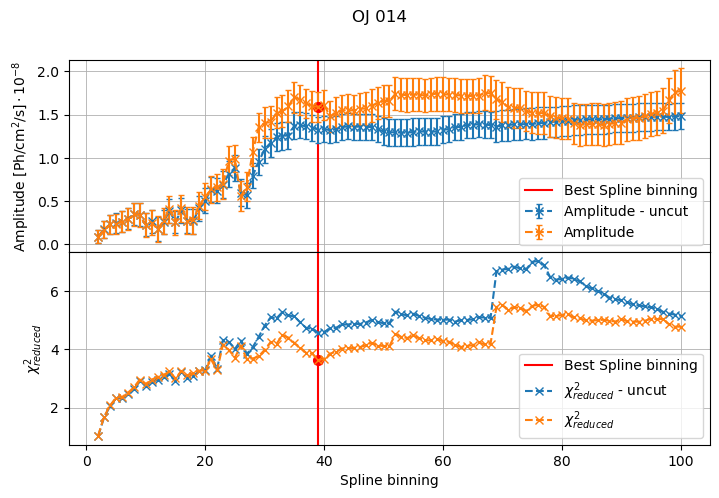

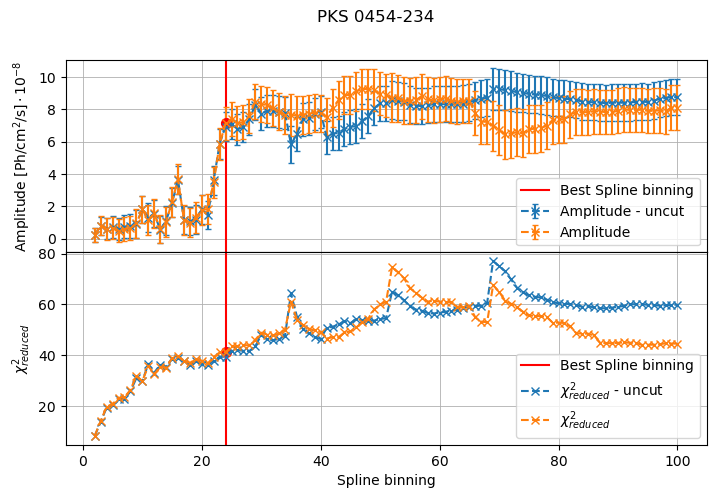

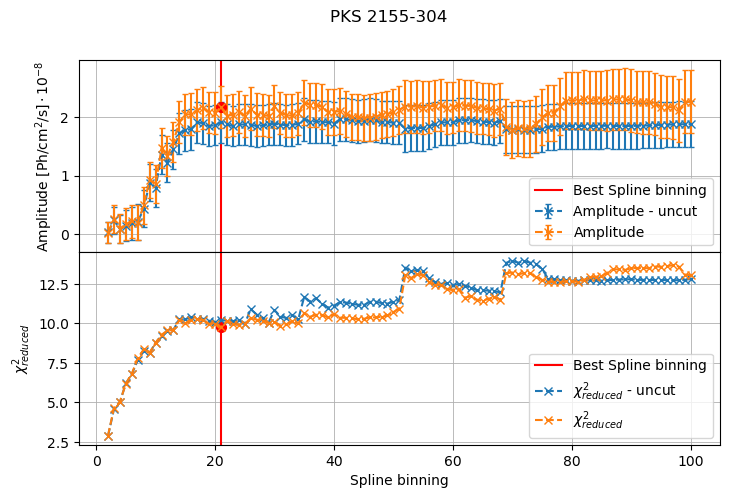

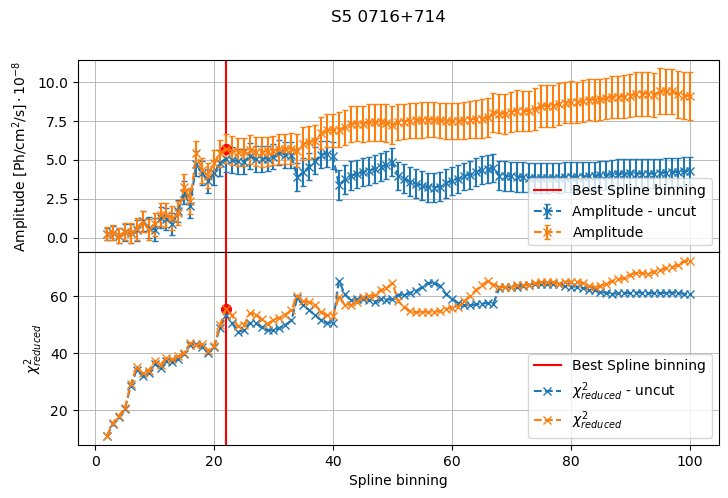

In [10]:
for k in data_out.keys():
    chired = data_out[k][0][3]
    chired_v2 = data_out[k][1][3]
    fig, (ax1, ax2) = plt.subplots(2, figsize=(8.27, 5), sharex=True)
#     fig.tight_layout()
    fig.suptitle(input_dict[k][8])
    fig.subplots_adjust(hspace=0)
    
    ax1.axvline(x=input_dict[k][7], color='r', label='Best Spline binning')
    ax2.axvline(x=input_dict[k][7], color='r', label='Best Spline binning')
    
    ax1.errorbar(data_out[k][1][0], list(map(abs, data_out[k][1][1])), yerr=data_out[k][1][2],marker = 'x', linestyle = '--', 
                label='Amplitude - uncut',capsize=2)
    ax1.errorbar(data_out[k][0][0], list(map(abs, data_out[k][0][1])), yerr=data_out[k][0][2], marker = 'x', linestyle = '--', 
                label='Amplitude',capsize=2)
    
    ax1.set_ylabel(r'Amplitude $[\mathrm{Ph}/\mathrm{cm}^2/\mathrm{s}]\cdot10^{-%s}$'% scaling_power)
#     ax1.set_xlabel('Spline_bin')
    ax1.legend(loc='lower right')
    ax1.grid(linewidth=0.6)
    
    ax1.plot(data_out[k][0][0][input_dict[k][7]-2], abs(data_out[k][0][1][input_dict[k][7]-2]), 'ro', markersize = 7)
    ax2.plot(data_out[k][0][0][input_dict[k][7]-2], data_out[k][0][3][input_dict[k][7]-2], 'ro', markersize = 7)
    
    ax2.plot(data_out[k][1][0], data_out[k][1][3], 'x--', label='$\chi^2_{reduced}$ - uncut')
    ax2.plot(data_out[k][0][0], data_out[k][0][3], 'x--', label='$\chi^2_{reduced}$')
    
    ax2.set_ylabel('$\chi^2_{reduced}$')
    ax2.set_xlabel('Spline binning')
    ax2.legend(loc='lower right')
    ax2.grid(linewidth=0.6)
    

    
    fig.savefig(standard_path+k+'/chi_reduced_Kilian.png',format='png',dpi=300)

# Amplitude festlegen und delta_F/F_mean berechnen

In [11]:
for k in data_out.keys():
    pos = input_dict[k][7]
    binning = data_out[k][0][0][pos-2]
    delta_F = data_out[k][0][1][pos-2]
    err_delta_F = data_out[k][0][2][pos-2]
    chi_red = data_out[k][0][3][pos-2]
    f_mean = data_out[k][0][4][pos-2]
    err_f_mean = data_out[k][0][5][pos-2]
    print(k, binning, delta_F, f_mean, delta_F/f_mean)
    print(f"{err_delta_F = }")
    print(f"{err_f_mean = }")
    print(f"{chi_red = }")
    print(f"{delta_F/f_mean = }")
    print(f"{np.sqrt((err_delta_F/f_mean)**2 + ((delta_F*err_f_mean)/f_mean**2)**2) = }")
    print(f"{max(data_out[k][0][3][20:]) = }")
    print(f"{max(data_out[k][1][3][20:]) = }")
    print(f"{min(data_out[k][0][3][:]) = }")
    print(f"{min(data_out[k][1][3][:]) = }")
    print()

PG_1553 29 -1.0034359845015126 4.147865617744407 -0.2419162231796644
err_delta_F = 0.09895389948388962
err_f_mean = 0.04658962774059187
chi_red = 2.2257868053956935
delta_F/f_mean = -0.2419162231796644
np.sqrt((err_delta_F/f_mean)**2 + ((delta_F*err_f_mean)/f_mean**2)**2) = 0.02401083064498759
max(data_out[k][0][3][20:]) = 2.52796930136892
max(data_out[k][1][3][20:]) = 2.832862381926404
min(data_out[k][0][3][:]) = 0.9883674827905764
min(data_out[k][1][3][:]) = 0.9786135165184976

OJ_014 39 -1.5897859686582545 2.6059567112784734 -0.610058471722775
err_delta_F = 0.1732239163654015
err_f_mean = 0.06390915447981614
chi_red = 3.621722022271037
delta_F/f_mean = -0.610058471722775
np.sqrt((err_delta_F/f_mean)**2 + ((delta_F*err_f_mean)/f_mean**2)**2) = 0.06813518982378082
max(data_out[k][0][3][20:]) = 5.536444935048904
max(data_out[k][1][3][20:]) = 7.035593953782139
min(data_out[k][0][3][:]) = 1.0370633982666109
min(data_out[k][1][3][:]) = 1.02594609612056

PKS_0454 24 7.128866332091617 16.42

## Eigene LCs